# INTRO
In this project, we compare two popular clustering algorithms, DBSCAN and K-means, using a dataset from the Kaggle competition "Tabular Playground Series - Jul 2022." We aim to analyze their performance and characteristics in clustering the tabular dataset. DBSCAN is a density-based algorithm that identifies clusters based on data point density, while K-means is a centroid-based algorithm that partitions the data into K clusters. By applying these algorithms and evaluating the resulting clusters, we gain insights into their strengths and limitations.

In [13]:
%%bash

mkdir data
cd data
git init
dvc init

Initialized empty Git repository in /Users/dominikludwiczak/OneDrive - put.poznan.pl/semestr 4/Data Mining/assignment3/data/.git/
Initialized DVC repository.

You can now commit the changes to git.

+---------------------------------------------------------------------+
|                                                                     |
|        DVC has enabled anonymous aggregate usage analytics.         |
|     Read the analytics documentation (and how to opt-out) here:     |
|             <https://dvc.org/doc/user-guide/analytics>              |
|                                                                     |
+---------------------------------------------------------------------+

What's next?
------------
- Check out the documentation: <https://dvc.org/doc>
- Get help and share ideas: <https://dvc.org/chat>
- Star us on GitHub: <https://github.com/iterative/dvc>


In [3]:
%cd data

/Users/dominikludwiczak/OneDrive - put.poznan.pl/semestr 4/Data Mining/assignment3/data


In [24]:
%%bash

dvc add dataset/data.csv


To track the changes with git, run:

	git add dataset/.gitignore dataset/data.csv.dvc

To enable auto staging, run:

	dvc config core.autostage true


In [25]:
%%bash

git add dataset/.gitignore dataset/data.csv.dvc
git commit -m "Added dataset"

[master (root-commit) 719d095] Added dataset
 5 files changed, 12 insertions(+)
 create mode 100644 .dvc/.gitignore
 create mode 100644 .dvc/config
 create mode 100644 .dvcignore
 create mode 100644 dataset/.gitignore
 create mode 100644 dataset/data.csv.dvc


In [27]:
%%bash
mkdir -p ../dvcrepo
dvc remote add -d repozytorium ../dvcrepo
git commit .dvc/config -m "Added local directory simulating remote data repository"

Setting 'repozytorium' as a default remote.
[master 3c885ed] Added local directory simulating remote data repository
 1 file changed, 4 insertions(+)


In [28]:
%%bash

dvc push

1 file pushed


# PREPROCESSING
In [Kaggle website](https://www.kaggle.com/competitions/tabular-playground-series-jul-2022/overview) we discovered that all numerical attributes have near-normal distribution, so we decided to transform categorical values to match normal distribution aswell. After distributions of all attributes resemble normal distribution we decided to standardize them. 

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, QuantileTransformer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE

In [4]:
df = pd.read_csv("dataset/data.csv").set_index('id')
df.head()

,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,...,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28
id,,,,,,,,,,,,,,,,,,,,,
0,-0.389420,-0.912791,0.648951,0.589045,-0.830817,0.733624,2.258560,2,13,14,...,-0.478412,-0.757002,-0.763635,-1.090369,1.142641,-0.884274,1.137896,1.309073,1.463002,0.813527
1,-0.689249,-0.453954,0.654175,0.995248,-1.653020,0.863810,-0.090651,2,3,6,...,-0.428791,-0.089908,-1.784204,-0.839474,0.459685,1.759412,-0.275422,-0.852168,0.562457,-2.680541
2,0.809079,0.324568,-1.170602,-0.624491,0.105448,0.783948,1.988301,5,11,5,...,-0.413534,-1.602377,1.190984,3.267116,-0.088322,-2.168635,-0.974989,1.335763,-1.110655,-3.630723
3,-0.500923,0.229049,0.264109,0.231520,0.415012,-1.221269,0.138850,6,2,13,...,0.619283,1.287801,0.532837,1.036631,-2.041828,1.440490,-1.900191,-0.630771,-0.050641,0.238333
4,-0.671268,-1.039533,-0.270155,-1.830264,-0.290108,-1.852809,0.781898,8,7,5,...,-1.628830,-0.434948,0.322505,0.284326,-2.438365,1.473930,-1.044684,1.602686,-0.405263,-1.987263


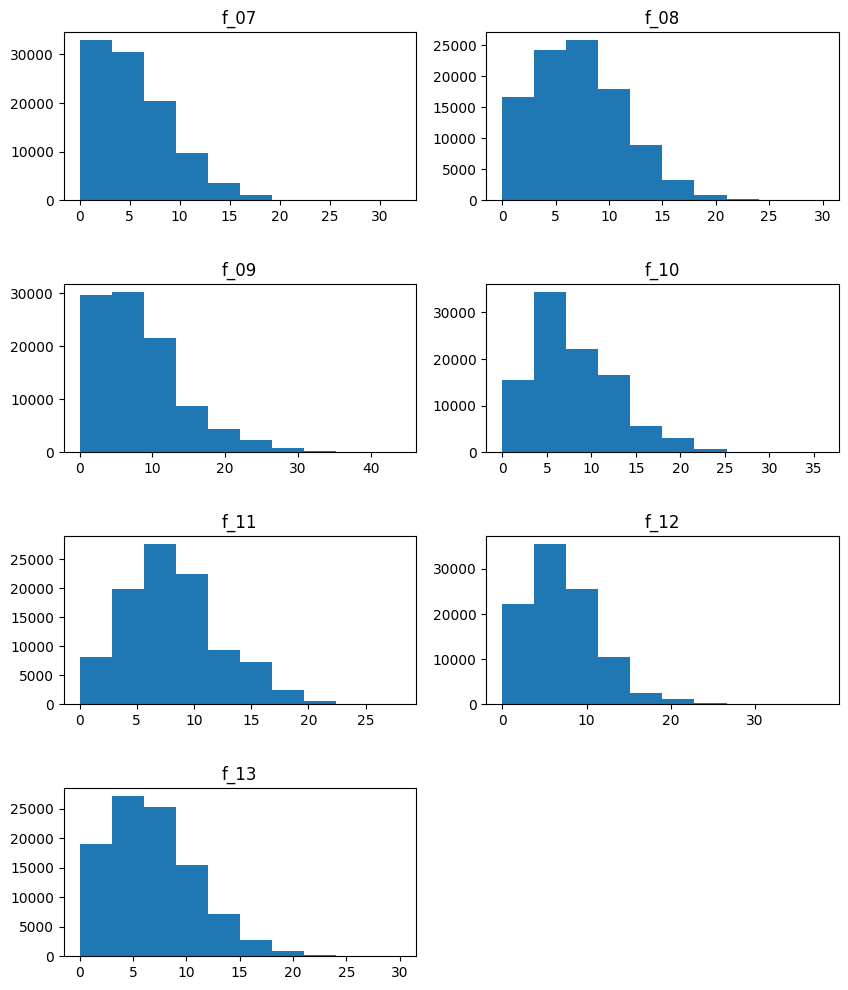

In [5]:
integers = df.select_dtypes(np.int64)

layout = (4, 2) 

fig, axes = plt.subplots(layout[0], layout[1], figsize=(10, 12))
fig.subplots_adjust(hspace=0.5)

for i, attribute in enumerate(integers.columns):
    row = i // layout[1]
    col = i % layout[1]

    axes[row, col].hist(integers[attribute], bins=10)
    axes[row, col].set_title(attribute)

if len(integers.columns) < (layout[0] * layout[1]):
    for i in range(len(integers.columns), (layout[0] * layout[1])):
        row = i // layout[1]
        col = i % layout[1]
        fig.delaxes(axes[row, col])

plt.show()

In [6]:
norm = QuantileTransformer(output_distribution='normal').fit(integers)
integers_normalized = pd.DataFrame(norm.transform(integers), columns=integers.columns)
df[integers_normalized.columns] = integers_normalized
df.head()

,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,...,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28
id,,,,,,,,,,,,,,,,,,,,,
0,-0.389420,-0.912791,0.648951,0.589045,-0.830817,0.733624,2.258560,-0.931971,1.397837,1.016672,...,-0.478412,-0.757002,-0.763635,-1.090369,1.142641,-0.884274,1.137896,1.309073,1.463002,0.813527
1,-0.689249,-0.453954,0.654175,0.995248,-1.653020,0.863810,-0.090651,-0.931971,-0.807429,-0.180377,...,-0.428791,-0.089908,-1.784204,-0.839474,0.459685,1.759412,-0.275422,-0.852168,0.562457,-2.680541
2,0.809079,0.324568,-1.170602,-0.624491,0.105448,0.783948,1.988301,-0.003764,0.993800,-0.397918,...,-0.413534,-1.602377,1.190984,3.267116,-0.088322,-2.168635,-0.974989,1.335763,-1.110655,-3.630723
3,-0.500923,0.229049,0.264109,0.231520,0.415012,-1.221269,0.138850,0.248427,-1.111702,0.895780,...,0.619283,1.287801,0.532837,1.036631,-2.041828,1.440490,-1.900191,-0.630771,-0.050641,0.238333
4,-0.671268,-1.039533,-0.270155,-1.830264,-0.290108,-1.852809,0.781898,0.718462,0.132113,-0.397918,...,-1.628830,-0.434948,0.322505,0.284326,-2.438365,1.473930,-1.044684,1.602686,-0.405263,-1.987263


In [7]:
scale = StandardScaler().fit(df)
df_scaled = pd.DataFrame(scale.transform(df), columns=df.columns)
df_scaled.head()

,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,...,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28
0,-0.389551,-0.917695,0.649105,0.589499,-0.824775,0.734849,2.267432,-0.547132,1.145437,0.858093,...,-0.471839,-0.754257,-0.762195,-0.711585,0.911572,-0.680948,0.762783,0.960482,1.045296,0.683323
1,-0.688544,-0.459195,0.654321,0.995533,-1.644472,0.864967,-0.087835,-0.547132,-0.543827,-0.069152,...,-0.422434,-0.089129,-1.783073,-0.541815,0.454693,1.032386,-0.133948,-0.552942,0.355435,-1.602671
2,0.805607,0.318753,-1.167963,-0.623531,0.108638,0.785146,1.996476,0.101057,0.835939,-0.237662,...,-0.407243,-1.597140,1.193015,2.236943,0.088090,-1.513324,-0.577814,0.979171,-0.926250,-2.224327
3,-0.500743,0.223305,0.264788,0.232124,0.417259,-1.219016,0.142257,0.277167,-0.776904,0.764448,...,0.621083,1.284518,0.534669,0.727667,-1.218753,0.825698,-1.164842,-0.397908,-0.114228,0.307002
4,-0.670613,-1.044343,-0.268745,-1.828801,-0.285713,-1.850223,0.786963,0.605403,0.175875,-0.237662,...,-1.617255,-0.433152,0.324273,0.218614,-1.484025,0.847369,-0.622034,1.166086,-0.385886,-1.149094


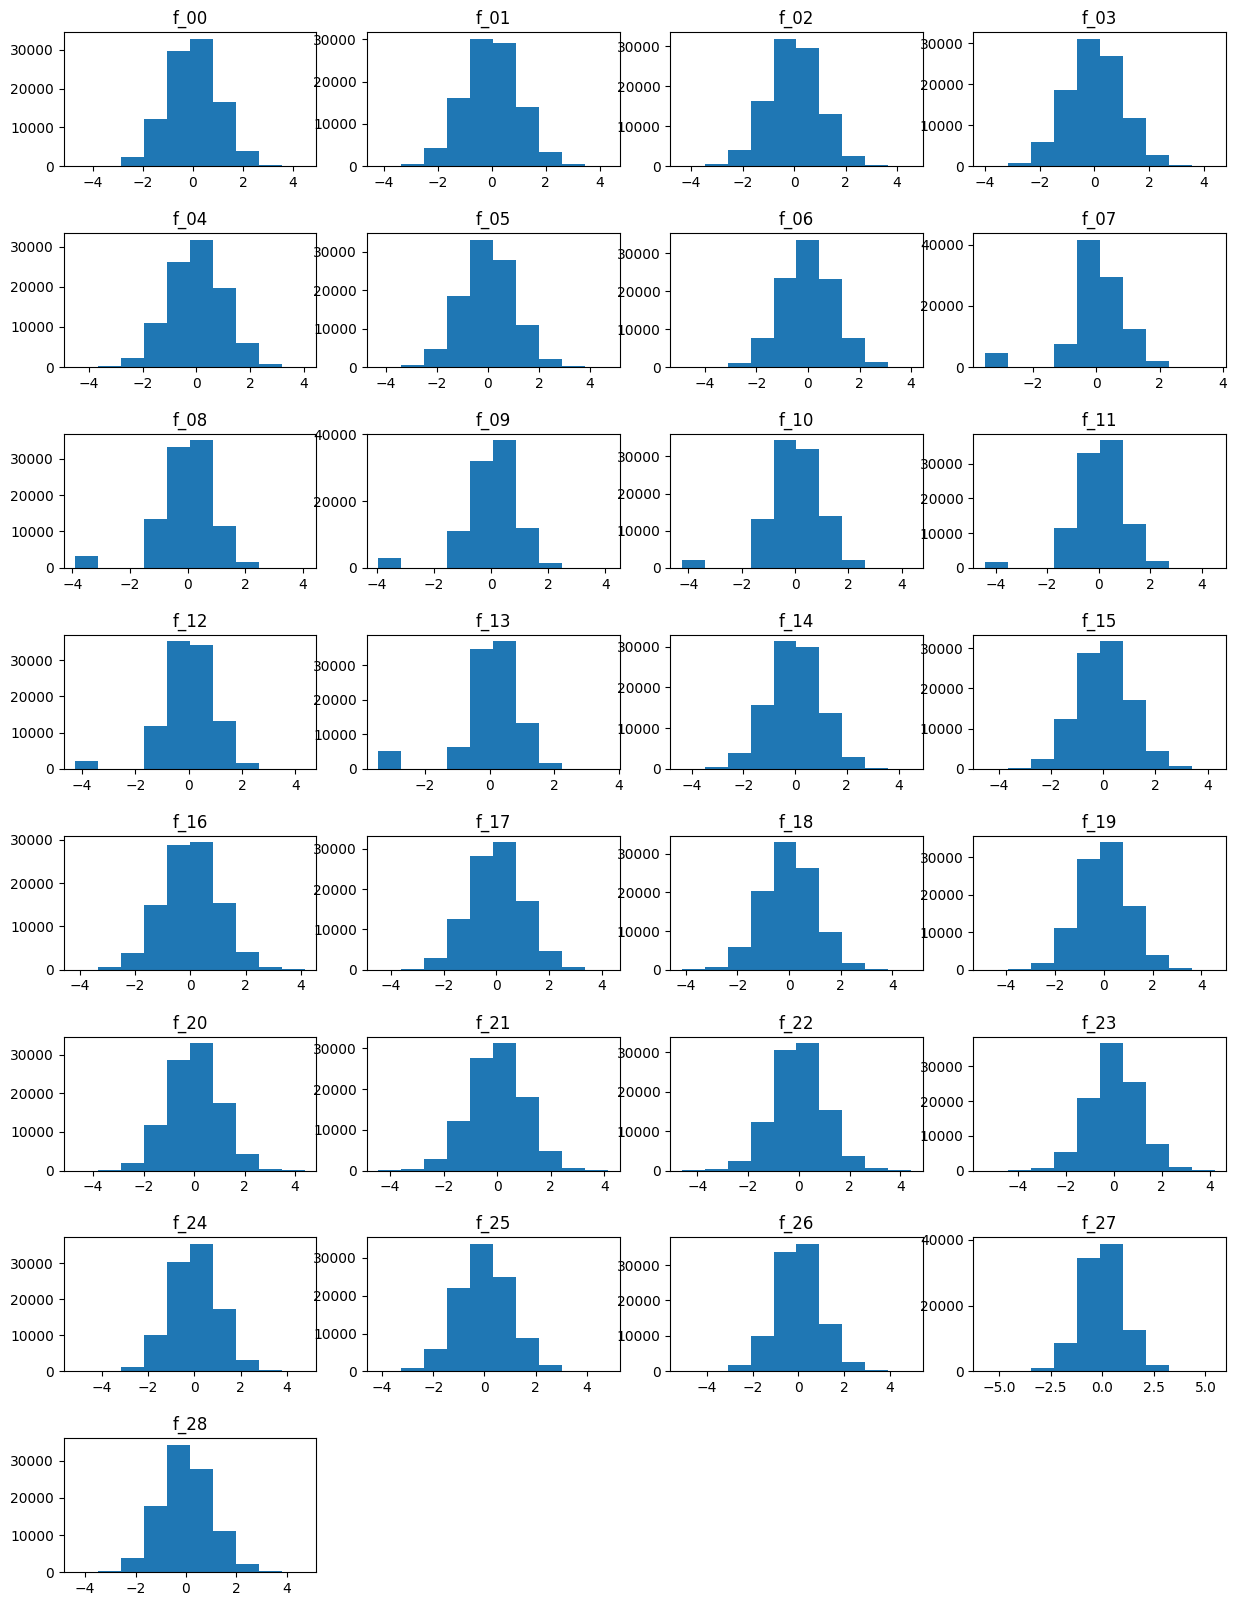

In [8]:
df = df_scaled
fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(15, 20))
fig.subplots_adjust(hspace=0.5)

axes = axes.flatten()

for i, attribute in enumerate(df_scaled.columns):
    axes[i].hist(df_scaled[attribute], bins=10)
    axes[i].set_title(attribute)
    
if len(df_scaled.columns) < len(axes):
    for j in range(len(df_scaled.columns), len(axes)):
        fig.delaxes(axes[j])

plt.show()

In [9]:
df.to_csv("dataset/data.csv")

In [ ]:
%%bash 

dvc add dataset/data.csv
git commit dataset/data.csv.dvc -m "Normalization"

dvc push


To track the changes with git, run:

	git add dataset/data.csv.dvc

To enable auto staging, run:

	dvc config core.autostage true
[master 8f00b97] Normalization
 1 file changed, 2 insertions(+), 2 deletions(-)
1 file pushed


# CHOOSING BEST K
While choosing best number of clusters for our algorithms we encountered couple of problems:
- Dataset was quite large especially with 29 attributes so computations took a long time
- Due to computational problems we decided to sample smaller set to tune hyperparameters on, which led to not consistent results depending on split 
- Metrics chosen to distinguish best numbers of clusters were sometimes conflicting

In [10]:
silhouette_Scores = list()
DB_Scores = list()
max_k=range(2,11)
sample_df = df.sample(frac=0.2, random_state=23)

for k in max_k:
    kmeans = KMeans(n_clusters=k)
    labels = kmeans.fit_predict(sample_df)
    s1 = silhouette_score(sample_df, labels, metric='euclidean')
    s2 = davies_bouldin_score(sample_df, labels)
    silhouette_Scores.append((k, s1))
    DB_Scores.append((k, s2))

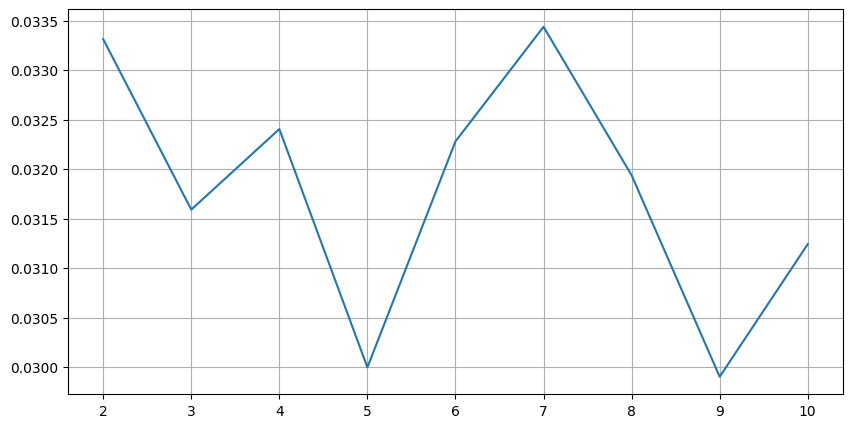

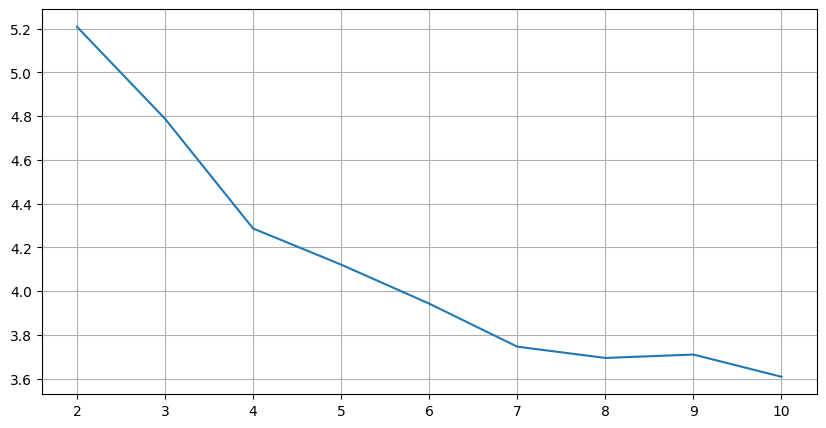

In [11]:
ax_x, ax_y = zip(*silhouette_Scores)
fig = plt.figure(figsize=(10,5))
ax = plt.axes()
plt.xticks(max_k)
plt.grid()
plt.plot(ax_x, ax_y)

ax_x, ax_y = zip(*DB_Scores)
fig = plt.figure(figsize=(10,5))
ax = plt.axes()
plt.xticks(max_k)
plt.grid()
plt.plot(ax_x, ax_y)

# KMEANS

Knowing all problems we stated earlier we decided to stick with 7 as best number of clusters in this particular split, since both metrics pointed towards it being decent

/usr/local/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


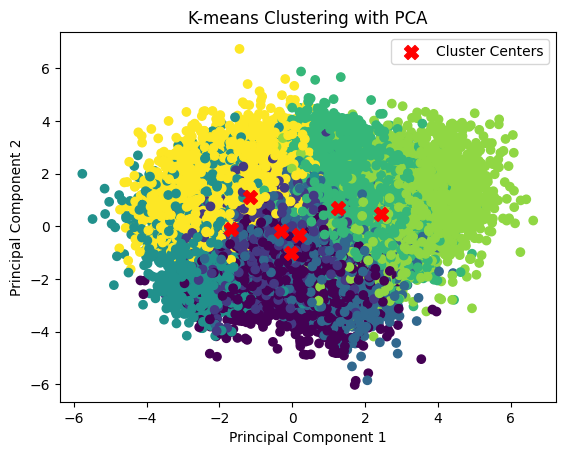

In [12]:
true_k = 7
pca = PCA(n_components=2)
data_pca = pca.fit_transform(df)

kmeans = KMeans(n_clusters=true_k, random_state=42)
labels = kmeans.fit_predict(df)

cluster_centers = pca.transform(kmeans.cluster_centers_)
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=labels, cmap='viridis')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='X', color='red', s=100, label='Cluster Centers')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-means Clustering with PCA')

plt.legend()
plt.show()

<AxesSubplot: >

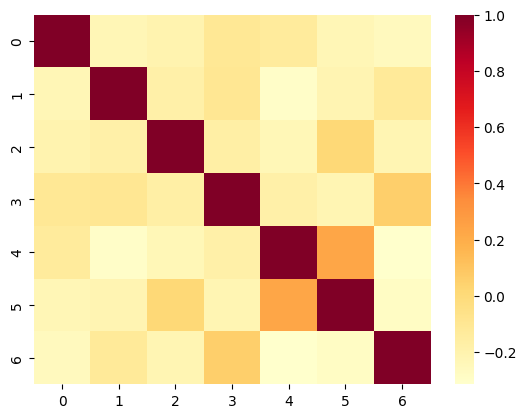

In [13]:
sns.heatmap(cosine_similarity(kmeans.cluster_centers_), cmap='YlOrRd')

As we can see there isn't much of similarity between selected clusters, which proves that clustering was indeed justified and more simillar groups can be distinguished

# DBSCAN

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


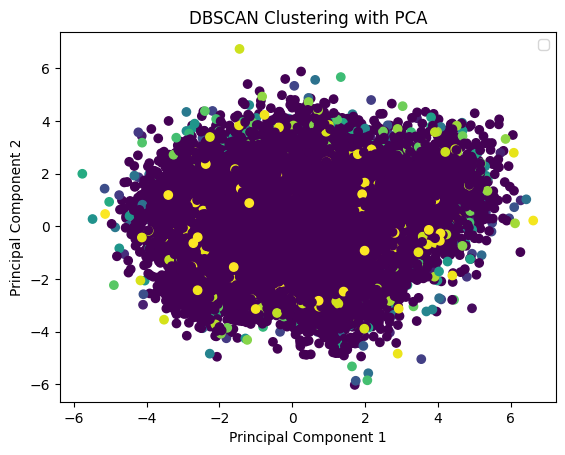

In [16]:
DB_model = DBSCAN(eps=5, min_samples=1)
labels = DB_model.fit_predict(df)

plt.scatter(data_pca[:, 0], data_pca[:, 1], c=labels, cmap='viridis')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('DBSCAN Clustering with PCA')

plt.legend()
plt.show()

Results of DBSCAN were rather lackluster no matter what parameters we tried using 

# SHORT SUMMARY
Based on the visualization of the dataset from the Kaggle competition "Tabular Playground Series - Jul 2022" using Principal Component Analysis (PCA), K-means exhibited better clustering performance compared to DBSCAN. The reduced-dimensional representation provided by PCA allowed for a clearer visualization of the clusters. K-means showed somewhat distinct and separated clusters, indicating its effectiveness in grouping similar data points. In contrast, DBSCAN resulted in less defined and more scattered clusters. These observations suggest that K-means was better suited for the dataset when considering the visual representation after PCA.